# Optyx: A ZX-based Python library for networked quantum architectures

## Hong-Ou-Mandel effect

### Experiment definition

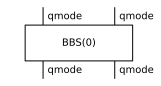

In [1]:
from optyx.photonic import BBS

beam_splitter = BBS(0)

beam_splitter.draw()

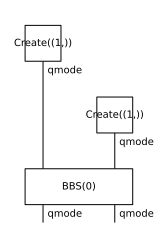

In [2]:
from optyx.photonic import Create

hong_ou_mandel = (
    Create(1) @ Create(1) >>
    beam_splitter
)

hong_ou_mandel.draw()

 ![HOM](./hom.png "Hong-Ou-Mandel Effect")

### Diagram evaluation

In [3]:
from optyx.classical import Select
(
    hong_ou_mandel >> Select(1, 1)
).eval().tensor.array

array(-0.+0.j)

In [4]:
hong_ou_mandel.eval().prob_dist()

{(0, 2): 0.5, (1, 1): 4.9303806576313227e-32, (2, 0): 0.5}

## Qubit teleportation - function syntax and backends

In [5]:
from optyx import qubit, bit
from optyx.qubits import Scalar

from optyx import Channel
from optyx.qubits import Z, X, H, Measure, Scalar, qubit, bit
from optyx.classical import BitControlledGate

### Define the protocol

In [6]:
@Channel.from_callable(
  dom=qubit @ qubit, cod=qubit @ qubit
)
def cnot(a, b):
  c, d = Z(1, 2)(a)
  Scalar(2 ** 0.5)()
  return X(2, 1)(c, b), d

<img src="teleport.svg" alt="Teleportation Protocol" width="800" style="max-width:100%;">


In [7]:
bell = Scalar(0.5 ** 0.5) @ Z(0, 2)

@Channel.from_callable(
  dom=qubit, cod=qubit
)
def teleportation(c):
  a, b = bell()
  aa, cc = cnot(a, c)
  c_ = Measure(1)(H()(cc))
  a_ = Measure(1)(aa)
  bb = BitControlledGate(X(1, 1, 0.5))(a_, b)
  return BitControlledGate(Z(1, 1, 0.5))(c_, bb)

In [8]:
teleportation_monoidal_syntax = (
    qubit @ bell >>
    cnot @ qubit >>
    H() @ qubit ** 2 >>
    Measure(1) @ Measure(1) @ qubit >>
    bit @ BitControlledGate(X(1, 1, 0.5)) >>
    BitControlledGate(Z(1, 1, 0.5))
)

### Verify the protocol

In [9]:
import numpy as np
from optyx.qubits import Id

np.allclose(
    teleportation.eval().tensor.array,
    Id(1).double().to_tensor().eval().array,
    teleportation_monoidal_syntax.eval().tensor.array
)

True

In [10]:
from optyx.core.backends import (
    DiscopyBackend,
    QuimbBackend
)

np.allclose(
    teleportation.eval(DiscopyBackend()).tensor.array,
    teleportation.eval(QuimbBackend()).tensor.array
)

True

## Fusion teleportation

Graphically, the fusion measurement we would like to use, takes the following form:

![Fusion II](./fusion_ii.png "Fusion measurement implementing a Bell measurement in dual rail encoding")


where $\underline{a}, \underline{b}, \underline{c}, \underline{d}$ are the measurement outcomes as the measured photon numbers. 

$\underline{s} = \underline{a} \oplus \underline{b}$

$\underline{k} = \underline{s} (\underline{b} + \underline{d}) + \neg \underline s (1 - \frac{\underline{a} + \underline{b}}{2})$

### Define the protocol

In [11]:
from optyx.classical import PostselectBit, BitControlledGate
from optyx.photonic import Phase
from optyx.photonic import HadamardBS, qmode

# postselect on fusion success
fusion_failure_processing = PostselectBit(1)

# apply the box if the control bit is 1, otherwise apply an identity channel
correction = BitControlledGate(
    HadamardBS() >>
    (Phase(0.5) @ qmode) >>
    HadamardBS()
)

In [12]:
from optyx.photonic import DualRail

dual_rail_encoded_bell = (
    bell >>
    DualRail(1) @ DualRail(1)
)

In [13]:
from optyx.photonic import FusionTypeII

@Channel.from_callable(
    dom=qubit, cod=qmode @ qmode
)
def fusion_teleportation(a):
    dual_rail_encoded_input = DualRail(1)(a)
    b, c, d, e = dual_rail_encoded_bell()
    s, k = FusionTypeII()(*dual_rail_encoded_input, b, c)
    fusion_failure_processing(s)
    dr_output_1, dr_output_2 = correction(k, d, e)
    return dr_output_1, dr_output_2

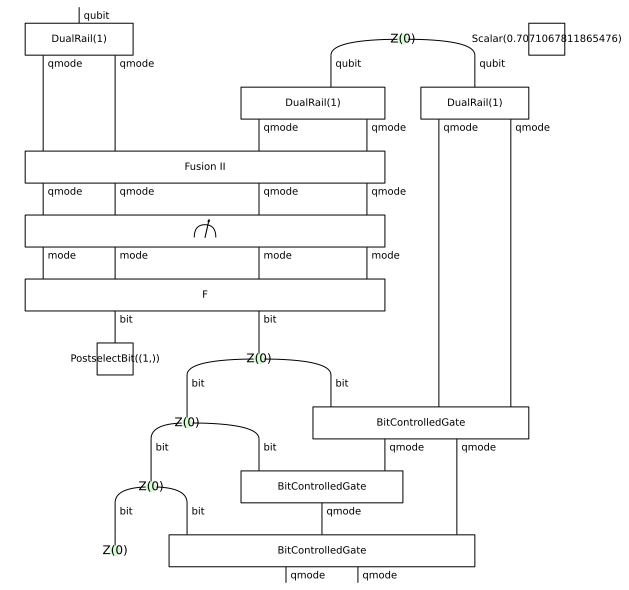

In [14]:
from optyx.photonic import FusionTypeII

fusion_teleportation_monoidal_syntax = (
    DualRail(1) @ dual_rail_encoded_bell >>
    FusionTypeII() @ qmode**2 >>
    fusion_failure_processing @ correction
)

array_teleportation = fusion_teleportation_monoidal_syntax.eval().tensor.array

fusion_teleportation_monoidal_syntax.foliation().draw(figsize=(8, 8))


### Verify the protocol

In [15]:
import numpy as np
from optyx.photonic import Id

array_dr = (DualRail(1) @ Scalar(0.5**0.5)).double().to_tensor().eval().array
np.allclose(array_teleportation[:, :, :2, :2, :2, :2], array_dr)


True

### Approximate contraction with Quimb and Cotengra

In [16]:
# process fidelity

def _flat(x):
    return np.asarray(x, dtype=complex).ravel()

# cosine similarity of pure unitary channels as superoperators
def process_fidelity(SU, SV):
    a, b = _flat(SU), _flat(SV)
    num = abs(np.vdot(a, b))
    den = np.linalg.norm(a) * np.linalg.norm(b)
    if den == 0:
        return 0.0
    return float(num / den)

def average_fidelity(SU, SV, d):
    Fp = process_fidelity(SU, SV)
    return float((d * Fp + 1) / (d + 1))

/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:329: UserWarning: Trial error: not enough values to unpack (expected 2, got 1). Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:329: UserWarning: Trial error: not enough values to unpack (expected 2, got 1). Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:329: UserWarning: Trial error: not enough values to unpack (expected 2, got 1). Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
/home/mateuszkupper/Documents/optyx/.venv/lib/python

Text(0.5, 1.0, 'Fusion-based Teleportation Fidelity vs Contraction Chi')

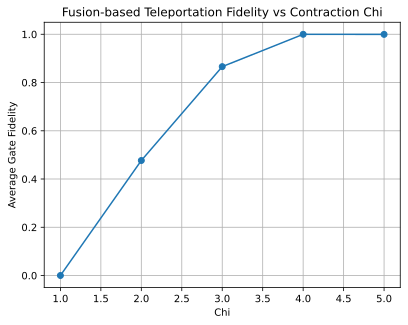

In [17]:
from cotengra import HyperCompressedOptimizer

errors = []
for chi in range(1, 6):
    optimiser = HyperCompressedOptimizer(
        chi=chi
    )
    error_for_chi = []
    for _ in range(10):
         error_for_chi.append(
             process_fidelity(
                 fusion_teleportation.eval(QuimbBackend(optimiser)).tensor.array,
                 array_teleportation
             )
         )
    errors.append(np.median(error_for_chi))

import matplotlib.pyplot as plt
plt.plot(range(1, 6), errors, marker='o')
plt.grid()
plt.xlabel('Chi')
plt.ylabel('Average Gate Fidelity')
plt.title('Fusion-based Teleportation Fidelity vs Contraction Chi')


### Photon loss and channel fidelity

In [18]:
from optyx.photonic import FusionTypeII, PhotonLoss

def fusion_teleportation_with_photon_loss(p):
    @Channel.from_callable(
        dom=qubit, cod=qmode**2
    )
    def fusion_teleportation(a):
        dr_input_1, dr_input_2 = DualRail(1)(a)
        b, c, d, e = dual_rail_encoded_bell()
        dr_input_1_loss, dr_input_2_loss, b_loss, c_loss, d_loss, e_loss = (
            PhotonLoss(p)(dr_input_1), PhotonLoss(p)(dr_input_2), PhotonLoss(p)(b), PhotonLoss(p)(c), PhotonLoss(p)(d), PhotonLoss(p)(e)
        )
        s, k = FusionTypeII()(dr_input_1_loss, dr_input_2_loss, b_loss, c_loss)
        fusion_failure_processing(s)
        output_rail_1, output_rail = correction(k, d_loss, e_loss)
        return output_rail_1, output_rail
    return fusion_teleportation

Text(0.5, 1.0, 'Fusion-based Teleportation: Success Probability vs Average Fidelity')

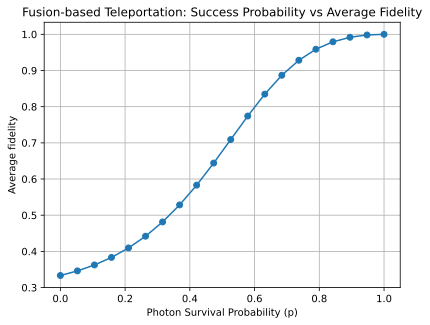

In [19]:
import numpy as np
import matplotlib.pyplot as plt

ps = np.linspace(0.0, 1.0, 20)

F_avg_vals = []
succ_probs = []
for p in ps:
    S_impl = fusion_teleportation_with_photon_loss(p).eval().tensor.array
    S_tgt  = array_teleportation
    s = average_fidelity(S_impl, S_tgt, d=2)

    succ_probs.append(s)

plt.figure()
plt.plot(ps, succ_probs, marker='o')
plt.grid(True)
plt.xlabel('Photon Survival Probability (p)')
plt.ylabel('Average fidelity')
plt.title('Fusion-based Teleportation: Success Probability vs Average Fidelity')


## Distributed entanglement generation

### Fusion and photon distinguishability

#### Define the protocol

In [20]:
internal_state_1 = [1, 0]
internal_state_2 = [0, 1]

print(internal_state_1, internal_state_2)

[1, 0] [0, 1]


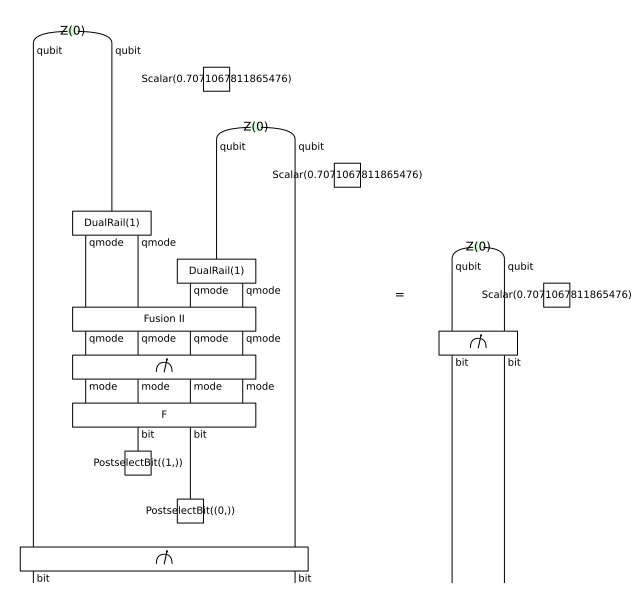

In [21]:
from optyx.qubits import Z, Scalar, Id, Measure
from optyx.photonic import DualRail
from optyx.classical import PostselectBit
from discopy.drawing import Equation

bell_state = Z(0, 2) @ Scalar(0.5 ** 0.5)
dual_rail_encoding = lambda state: DualRail(1, internal_states=[state])
encoding_layer =  dual_rail_encoding(internal_state_1) @ dual_rail_encoding(internal_state_2)

post_select = PostselectBit(1) @ PostselectBit(0)

protocol = (
    bell_state @ bell_state >>
    Id(1) @ (encoding_layer >> FusionTypeII() >> post_select) @ Id(1)
)
measure = Measure(2)

Equation(protocol >> measure, bell_state >> measure).draw(figsize=(8, 8))

#### Define a set of internal states with varying degrees of distinguishability

In [22]:
import math

def rotated_unit_vectors(n: int = 10):
    for i in range(n):
        theta = i * (math.pi / 2) / (n - 1)
        yield (math.cos(theta), math.sin(theta))

unit_vectors = list(rotated_unit_vectors(15))

#### Run the experiments

In [23]:
from optyx.qubits import Discard

inner_product_states = []
inner_product_bell_states = []

result_bell = bell_state.eval().tensor.array.flatten()
result_bell = result_bell / np.linalg.norm(result_bell)

for vector in unit_vectors:
    encoding_layer =  dual_rail_encoding(internal_state_1) @ dual_rail_encoding(vector)
    experiment = bell_state @ bell_state >> Id(1) @ (encoding_layer >> FusionTypeII()
                                                                                >> post_select) @ Id(1)

    f = (experiment >> bell_state.dagger()).inflate(2).eval().tensor.array
    normalisation = (experiment >> Discard(2)).inflate(2).eval().tensor.array

    inner_product_states.append(np.inner(vector, internal_state_1))
    inner_product_bell_states.append(f/normalisation)

/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


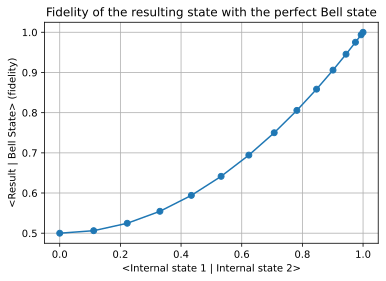

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(inner_product_states, inner_product_bell_states, marker='o')
plt.xlabel('<Internal state 1 | Internal state 2>')
plt.ylabel('<Result | Bell State> (fidelity)')
plt.title('Fidelity of the resulting state with the perfect Bell state')
plt.grid(True)
plt.show()

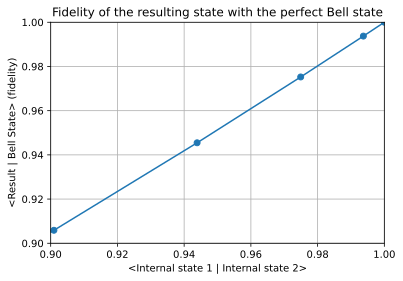

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(inner_product_states, inner_product_bell_states, marker='o')
plt.xlabel('<Internal state 1 | Internal state 2>')
plt.ylabel('<Result | Bell State> (fidelity)')
plt.title('Fidelity of the resulting state with the perfect Bell state')
plt.xlim(0.9, 1)
plt.ylim(0.9, 1)
plt.grid(True)
plt.show()

## Interfacing with external libraries

### Graphix

In [26]:
import graphix
from optyx import qubits

circuit = graphix.Circuit(2)
circuit.cnot(0, 1)

pattern = circuit.transpile().pattern

The pattern is not consistent with flow or gflow structure.


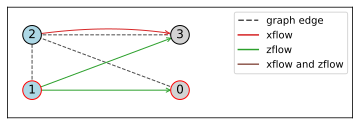

In [27]:
pattern.draw_graph()

In [28]:
simulator = graphix.simulator.PatternSimulator(pattern, backend="statevector")
graphix_result = simulator.run().psi.conj()

In [29]:
optyx_zx = qubits.Circuit(pattern)

optyx_res = (
    qubits.Ket("+")**2 >> optyx_zx
).eval().amplitudes()

In [30]:
for keys in optyx_res.keys():
    assert np.isclose(optyx_res[keys], graphix_result[keys], atol=1e-6)

### Perceval circuits and processors

In [31]:
import perceval as pcvl

#### Define the protocol in Perceval

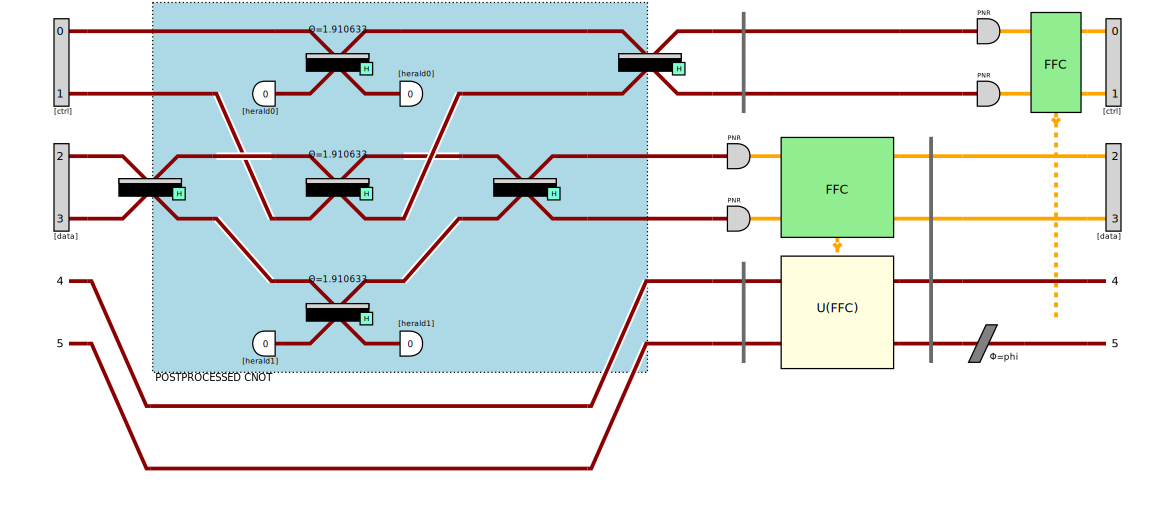

In [32]:
p = pcvl.Processor("SLOS", 6)
p.add(0, pcvl.catalog["postprocessed cnot"].build_processor())

p.add(0, pcvl.BS.H())
p.add(0, pcvl.Detector.pnr())
p.add(1, pcvl.Detector.pnr())
p.add(2, pcvl.Detector.pnr())
p.add(3, pcvl.Detector.pnr())

ff_X = pcvl.FFCircuitProvider(
  2, 0, pcvl.Circuit(2)
)
ff_X.add_configuration(
  [0, 1], pcvl.PERM([1, 0])
)
p.add(2, ff_X)

phi = pcvl.P("phi")
ff_Z = pcvl.FFConfigurator(
  2, 3,
  pcvl.PS(phi),
  {"phi": 0}
).add_configuration(
  [0, 1],
  {"phi": np.pi}
)
p.add(0, ff_Z)

pcvl.pdisplay(p, recursive=True)

In [33]:
from optyx.qubits import Ket

state = Ket("+") >> Z(1, 1, 0.3)
state_array = state.eval().tensor.array
state_array = state_array / np.linalg.norm(state_array)

#### Evaluate the protocol in Perceval

In [34]:
to_transmit = (complex(state_array[0])*pcvl.BasicState([1, 0]) +
               complex(state_array[1])*pcvl.BasicState([0, 1]))

sg = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
bell_state = sg.bell_state("phi+")

input_state = to_transmit * bell_state
p.min_detected_photons_filter(2)

input_state *= pcvl.BasicState([0, 0])

p.with_input(input_state)

In [35]:
result_perceval = p.probs()

#### Convert to Optyx and simulate

In [36]:
from optyx import Channel

optyx_diagram = Channel.from_perceval(p)

In [37]:
from optyx.qubits import Scalar, Ket
from optyx.photonic import DualRail

bell_state = Z(0, 2) @ Scalar(0.5**0.5)
transmit = Ket("+") >> Z(1, 1, 0.3)

input_state = transmit @ bell_state

protocol = (
    input_state >>
    DualRail(3) >>
    Channel.from_perceval(p)
)

In [38]:
result_optyx = protocol.eval().prob_dist()

In [39]:
def check_dict_agreement(d1, d2, rtol=1e-5, atol=1e-8):
    for key in d1.keys() - d2.keys():
        assert np.isclose(d1[key], 0, rtol=rtol, atol=atol)
    for key in d2.keys() - d1.keys():
        assert np.isclose(d2[key], 0, rtol=rtol, atol=atol)
    for key in d1.keys() & d2.keys():
        assert np.isclose(d1[key], d2[key], rtol=rtol, atol=atol)

In [40]:
check_dict_agreement(
    {tuple(k): v for k, v in dict(result_perceval["results"]).items()},
    result_optyx
)